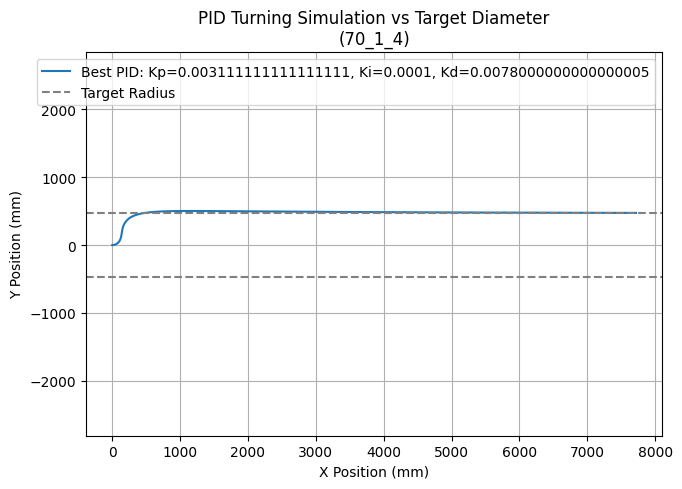

           Kp        Ki      Kd       Error  Simulated Diameter
107  0.003111  0.000100  0.0078   68.481675         1004.999275
108  0.003111  0.000100  0.0089   72.159122         1008.676722
109  0.003111  0.000100  0.0100   76.403914         1012.921514
29   0.001000  0.001189  0.0100   93.972753          842.544847
106  0.003111  0.000100  0.0067  168.101111         1104.618711


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from itertools import product

# --------------------------
# CONFIG
# --------------------------
SCALE_MM_PER_PX = 0.8
T_total = 63.0  # Video duration
dt = 0.01

# --------------------------
# HELPERS
# --------------------------
def extract_t1_t2_from_filename(filename):
    match = re.search(r'\((\d+)_+(\d+)_+(\d+)\)', filename)
    if match:
        base = int(match.group(1))
        left = int(match.group(2))
        right = int(match.group(3))
        return base * left, base * right, f"{base}_{left}_{right}"
    raise ValueError("Filename does not match expected format")

def get_velocity(t1, t2):
    frequency_hz = 1000 / (t1 + t2)
    return 75 * np.sqrt(frequency_hz)  # mm/s

def get_target_diameter_mm(csv_path, control_string):
    df = pd.read_csv(csv_path, skiprows=1)
    match_row = df[df['Video name'].astype(str).str.contains(control_string, na=False)]
    if match_row.empty:
        raise ValueError(f"No match in CSV for {control_string}")
    turning_diameter_px = float(match_row['Turning Diameter (px)'].values[0])
    return turning_diameter_px * SCALE_MM_PER_PX  # mm

def update_pid(current, target, dt, state, Kp, Ki, Kd):
    error = target - current
    state['integral'] += error * dt
    derivative = (error - state['prev_error']) / dt
    control = Kp * error + Ki * state['integral'] + Kd * derivative
    state['prev_error'] = error
    return control, state

def simulate_pid_path(Kp, Ki, Kd, target_diameter, base_speed, curvature_gain=1.0):
    state = {'integral': 0.0, 'prev_error': 0.0}
    angle = 0.0
    x, y = [0], [0]

    for _ in np.arange(0, T_total, dt):
        current_diameter = 2 * max(abs(y[-1]), 1e-6)
        control, state = update_pid(current_diameter, target_diameter, dt, state, Kp, Ki, Kd)
        bias = np.clip(1.0 + control, 0.5, 2.0)
        curvature = (bias - 1.0) * curvature_gain
        angle += curvature * dt
        dx = base_speed * np.cos(angle) * dt
        dy = base_speed * np.sin(angle) * dt
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)

    sim_diameter = np.max(np.abs(y)) * 2
    return np.array(x), np.array(y), sim_diameter

# --------------------------
# RUN FULL PID GRID SEARCH
# --------------------------
def run_pid_grid_search(filename, csv_path):
    t1, t2, control_string = extract_t1_t2_from_filename(filename)
    base_speed = get_velocity(t1, t2)
    target_diameter = get_target_diameter_mm(csv_path, control_string)

    Kp_vals = np.linspace(0.001, 0.02, 10)
    Ki_vals = np.linspace(0.0001, 0.005, 10)
    Kd_vals = np.linspace(0.0001, 0.01, 10)

    results = []
    for Kp, Ki, Kd in product(Kp_vals, Ki_vals, Kd_vals):
        _, _, sim_diameter = simulate_pid_path(Kp, Ki, Kd, target_diameter, base_speed)
        error = abs(sim_diameter - target_diameter)
        results.append({'Kp': Kp, 'Ki': Ki, 'Kd': Kd, 'Error': error, 'Simulated Diameter': sim_diameter})

    df = pd.DataFrame(results).sort_values(by='Error')
    best = df.iloc[0]
    x_best, y_best, _ = simulate_pid_path(best['Kp'], best['Ki'], best['Kd'], target_diameter, base_speed)

    # Plotting
    plt.figure(figsize=(7, 5))
    plt.plot(x_best, y_best, label=f"Best PID: Kp={best['Kp']}, Ki={best['Ki']}, Kd={best['Kd']}")
    plt.axhline(target_diameter / 2, color='gray', linestyle='--', label='Target Radius')
    plt.axhline(-target_diameter / 2, color='gray', linestyle='--')
    plt.title(f"PID Turning Simulation vs Target Diameter\n({control_string})")
    plt.xlabel("X Position (mm)")
    plt.ylabel("Y Position (mm)")
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df.head()

# --------------------------
# EXAMPLE USAGE
# --------------------------
filename = '10_17(70_1_4).csv'
csv_path = '/content/Thesis_Data.csv'

top_results = run_pid_grid_search(filename, csv_path)
print(top_results)
